In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from MSD_Conversion import msdHDF5toCSV, hdf5_getters
from pprint import pprint
from pyspark.sql import SparkSession
import time

#Start stopwatch
startTime = time.time()

# New API
spark_session = SparkSession\
        .builder\
        .master("local[1]") \
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",4)\
        .appName("million_songs_data")\
        .getOrCreate()

# Old API (RDD)
spark_context = spark_session.sparkContext

msdHDF5toCSV.main()

endTime = time.time()

print("Time Elapsed {}".format((endTime-startTime)/60))

FileNotFoundError: [Errno 2] No such file or directory: 'hdfs://192.168.1.153:9000/team09/SongCSV.csv'

In [26]:
data_frame = spark_session.read\
    .option("header", "true")\
    .csv('file:///home/ubuntu/Data-Millionare/SongCSV.csv')\
    .cache()

In [27]:
data_frame.show()

+----------+--------------------+-------+--------------------+--------------------+--------------+--------------------+---------------+--------------------+------------+---------+------------+----------------------+-------+-------------+-----------------------+--------------------+----+
|SongNumber|              SongID|AlbumID|           AlbumName|            ArtistID|ArtistLatitude|      ArtistLocation|ArtistLongitude|          ArtistName|Danceability| Duration|KeySignature|KeySignatureConfidence|  Tempo|TimeSignature|TimeSignatureConfidence|               Title|Year|
+----------+--------------------+-------+--------------------+--------------------+--------------+--------------------+---------------+--------------------+------------+---------+------------+----------------------+-------+-------------+-----------------------+--------------------+----+
|     10002|b'SOVLGJY12A8C13F...| 223563|b'Call of the Mas...|b'ARMQHX71187B989...|          null|       b'Atlanta GA'|           null| 

In [31]:
duration = data_frame.select('Duration')
print(duration.count())
duration_filtered = duration.filter(duration['Duration'].isNotNull())
duration.show()
duration_filtered.count()

10001
+---------+
| Duration|
+---------+
|280.21506|
|214.83057|
| 82.31138|
|289.38404|
|242.12853|
|   1.2273|
|205.00853|
| 33.09669|
|437.31546|
| 17.73669|
|293.19791|
|190.82404|
|229.53751|
|223.81669|
|224.28689|
|250.48771|
|287.08526|
|279.90159|
|295.60118|
|150.17751|
+---------+
only showing top 20 rows



10001

In [37]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def time_conversion(duration):
    duration_in_half_minutes = duration/30
    discretitized_duration = round(duration_in_half_minutes)
    discretized_duration_in_minutes = discretitized_duration/2
    return discretized_duration_in_minutes

udf_time_conversion = udf(time_conversion, FloatType())

duration_filtered = duration_filtered.withColumn('Duration', duration_filtered['Duration'].cast(FloatType()))

discrete_duration = duration_filtered.withColumn('Discrete duration', udf_time_conversion('Duration'))
discrete_duration.show()

+---------+-----------------+
| Duration|Discrete duration|
+---------+-----------------+
|280.21506|              4.5|
|214.83057|              3.5|
| 82.31138|              1.5|
|289.38403|              5.0|
|242.12852|              4.0|
|   1.2273|              0.0|
|205.00853|              3.5|
| 33.09669|              0.5|
|437.31546|              7.5|
| 17.73669|              0.5|
| 293.1979|              5.0|
|190.82404|              3.0|
| 229.5375|              4.0|
| 223.8167|              3.5|
| 224.2869|              3.5|
|250.48772|              4.0|
|287.08527|              5.0|
|279.90158|              4.5|
|295.60117|              5.0|
| 150.1775|              2.5|
+---------+-----------------+
only showing top 20 rows



In [44]:
discrete_duration_grouped = discrete_duration.groupBy('Discrete duration').count().sort('Discrete duration', ascending=True)
discrete_duration_grouped.show()

+-----------------+-----+
|Discrete duration|count|
+-----------------+-----+
|              0.0|   19|
|              0.5|  102|
|              1.0|  145|
|              1.5|  229|
|              2.0|  499|
|              2.5|  986|
|              3.0| 1496|
|              3.5| 1633|
|              4.0| 1558|
|              4.5| 1120|
|              5.0|  703|
|              5.5|  450|
|              6.0|  279|
|              6.5|  191|
|              7.0|  149|
|              7.5|   96|
|              8.0|   77|
|              8.5|   71|
|              9.0|   48|
|              9.5|   25|
+-----------------+-----+
only showing top 20 rows



In [47]:
discrete_duration_grouped.coalesce(1).write.csv('duration_distribution.csv')

In [51]:
discrete_duration_list = discrete_duration_grouped.select("Discrete duration").rdd.flatMap(lambda x: x).collect()
discrete_duration_count_list = discrete_duration_grouped.select("count").rdd.flatMap(lambda x: x).collect()
print(discrete_duration_list)

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 19.0, 20.0, 20.5, 21.0, 21.5, 23.0, 23.5, 25.5, 26.5, 27.0, 28.0, 30.5]


In [56]:
import matplotlib.pyplot as plt

<BarContainer object of 49 artists>

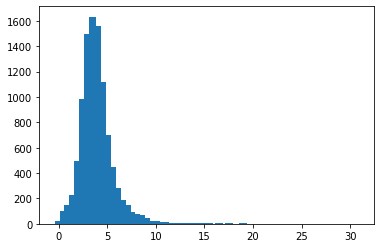

In [57]:
plt.bar(discrete_duration_list, discrete_duration_count_list)